# Desbalanceamento

Notice: Cada amostra da base de dados apresenta apenas um tipo defeito dentre Desalinhamento, Desbalanceamentos horizontal e vertical. Cada um será analisado separadamente.

### Objetivo 
Encontar (1)as melhores features e  (2)o melhor modelo para regressão da severidade do **Desbalanceamento**

In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aux_functions as aux   # biblioteca particular em arquivo anexo

sns.set_theme()

In [2]:
df = pd.read_csv('../data.csv')

# separa apenas amostras com defeito de DESBALANCEAMENTO
df =  df.query("defeito == 'desbalanceamento' or defeito == 'normal'")
# reinicia o index
df = df.reset_index(drop=True)

# # descarta a coluna 'defeito', agora redundante
# df.pop('defeito')
# # descarta a coluna 'rotacao' pois a velocidade extraída do tacometro representa melhor o rotor
# df.pop('rotacao')
# # descarta dados do microfone, pois estão em unidade diferente das acelerações e  não colaboram para a análise
# df = df.drop(['microfone_1h', 'microfone_2h', 'microfone_3h', 'microfone_entr', 'microfone_kurt', 'microfone_rms'], axis=1)

# separa apenas rotações acima de 30 Hz
df = df.query("fundamental > 30")
# filtra apenas duas variáveis regressoreas
df = df[['severidade', 'fundamental', 'tg1_rms']]

# exibe fragmento dos dados
df.iloc[:,:6].head()

,severidade,fundamental,tg1_rms
18,10.0,31.0620,10.445141
19,10.0,32.0640,11.535725
20,10.0,32.8656,13.380112
21,10.0,33.6672,13.339474
22,10.0,35.2704,14.438661


Separa-se a coluna com o valor que será estimado antes de definir os regressores

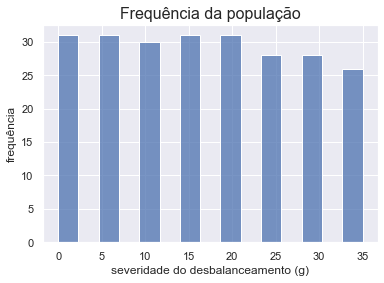

In [3]:
# armazena output em um array
output = np.array(df['severidade'])
# remove a coluna de outputs do df original
df.pop('severidade')

# plota distribuição da população
sns.histplot(output, bins=15)
plt.title('Frequência da população', fontsize=16)
plt.xlabel('severidade do desbalanceamento (g)')
plt.ylabel('frequência')
plt.show()

# Regressores

### Dados Originais

In [4]:
df.head()

,fundamental,tg1_rms
18,31.0620,10.445141
19,32.0640,11.535725
20,32.8656,13.380112
21,33.6672,13.339474
22,35.2704,14.438661


### Dados normalizados pelo inverso da rotação

In [5]:
df_norm = pd.DataFrame(df['fundamental'])
for col in df.columns[1:]:
    df_norm[col + '/v'] = df[col] / df['fundamental']

df_norm.head()

,fundamental,tg1_rms/v
18,31.0620,0.336267
19,32.0640,0.359772
20,32.8656,0.407116
21,33.6672,0.396216
22,35.2704,0.409371


### Dados normalizados pelo inverso da rotação AO QUADRADO

In [6]:
df_sqr_norm = pd.DataFrame(df['fundamental'])
for col in df.columns[1:]:
    df_sqr_norm[col + '/v^2'] = df[col] / df['fundamental']**2
df_sqr_norm.head()

,fundamental,tg1_rms/v^2
18,31.0620,0.010826
19,32.0640,0.011220
20,32.8656,0.012387
21,33.6672,0.011769
22,35.2704,0.011607


# Avaliação de modelos
Será utilizado o K-Fold Crossvalidation

In [7]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GroupKFold, StratifiedKFold

# kfold =           KFold(n_splits=8, shuffle=True, random_state=42)
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoLarsCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import sklearn.metrics as metrics

## Dados não normalizados

In [9]:
def avaliar_modelos(regressores):
    # salva a ordem das features
    feature_list = list(regressores[0])
    # converte df para array
    data = np.array(regressores[0])

    modelos = [
        ('Regressão linear', LinearRegression()  ),
        ('Arvore de decisão regressora',  DecisionTreeRegressor()  ),
        ('Floresta aleatória regressora', RandomForestRegressor(n_estimators= 10, random_state=42)  ),
    ]

    # aplica o cross-validation
    scores=[]
    for modelo in modelos:
        score = cross_val_score(modelo[1], data, output, cv=kfold, scoring='neg_root_mean_squared_error', n_jobs=-1)
        scores.append(score)

    # resume os scores em um DataFrame
    df_scores = pd.DataFrame()
    for i, modelo in enumerate(modelos):
        df_scores[ modelo[0] ] = -scores[i]
    
    df_scores = df_scores.melt().sort_values('value')
    df_scores.rename(columns={'variable':'modelo', 'value':"RMSE"}, inplace=True)
    df_scores['regressores'] = regressores[1]

    return df_scores


In [10]:
grupo_regressores = [
    (df,          'original'),
    (df_norm,     'normalizado 1/vel'),
    (df_sqr_norm, 'normalizado 1/v^2'),
]


df_scores_TOT = pd.DataFrame()
for dados in grupo_regressores:
    df_scores_TOT = pd.concat([df_scores_TOT, avaliar_modelos(dados)])

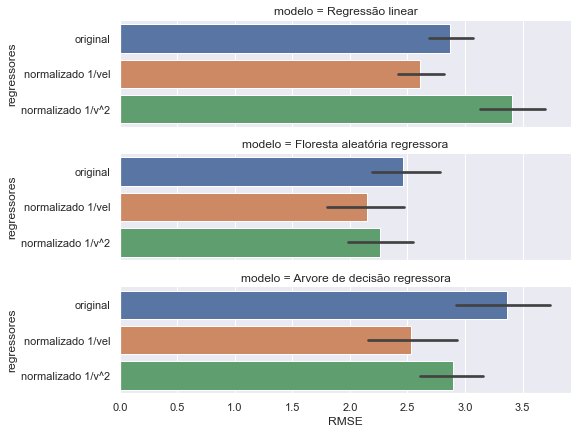

In [11]:
# plota o score de cada modelo em cada fold
sns.catplot(data=df_scores_TOT.sort_values(['modelo', 'regressores'], ascending=False), y='regressores', x="RMSE", 
            kind="bar", orient='h', row='modelo', height=2, aspect=4);

Conclusão: em todos os casos, o desempenho do modelo melhora após a normalização

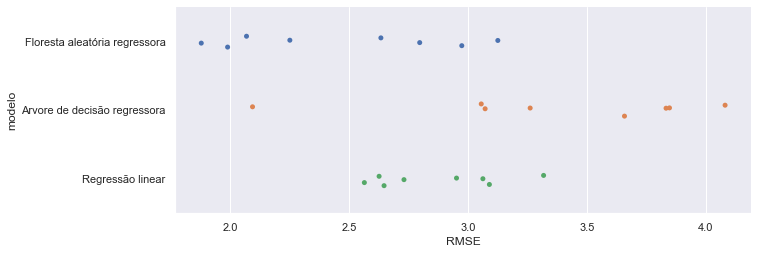

In [12]:
# plota o score de cada modelo em cada fold
sns.catplot(data=df_scores_TOT.query("regressores == 'original'"), y='modelo', x="RMSE",  
            orient='h', height=3.5, aspect=3);

# Visualizando modelos com Train-Test Split

## Modelos lineares

In [13]:
regressores = df

# salva a ordem das features
feature_list = list(regressores.columns)
# converte df para array
data = np.array(regressores)

In [14]:
modelos = [
    ('Regressão linear', LinearRegression()  ),
    ('Árvore de decisão regressora',  DecisionTreeRegressor()  ),
    ('Floresta aleatória regressora', RandomForestRegressor(n_estimators= 10, random_state=42)  ), 
]

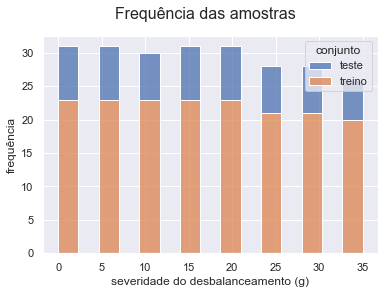

In [15]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size = 0.25, stratify=output, random_state=42) 

output_amostrado = pd.DataFrame( {'severidade': np.concatenate((y_test, y_train)),
                                  'fundamental': np.concatenate((X_test[:,0], X_train[:,0])),
                                  'conjunto': ['teste']*len(y_test) + ['treino']*len(y_train)} )

sns.histplot(output_amostrado, x='severidade', stat="count", multiple="stack", hue='conjunto', bins=15)
plt.suptitle('Frequência das amostras', fontsize=16)
plt.xlabel('severidade do desbalanceamento (g)')
plt.ylabel('frequência');

# sns.jointplot(data=output_amostrado, x='severidade', y='fundamental', hue='conjunto',
#                 kind='hist', bins=30, marginal_ticks=True, marginal_kws=dict(bins=15, fill=False, multiple="stack"));

In [16]:
resultados = [None]*len(modelos)
metricas = pd.DataFrame()

for i, modelo in enumerate(modelos):
    # treina os modelos com dados de treino
    modelo[1].fit(X_train, y_train)

    # prevê com o modelo a partir do conjunto de teste
    y_predicted = modelo[1].predict(X_test)

    # salva DataFrame com resultados
    resultados[i] = aux.gera_df_resultados(X_test, feature_list, y_predicted, y_test)

    # salva métricas com o desempenho do modelo
    metricas = pd.concat([ metricas, aux.gera_df_metricas(y_predicted, y_test, modelo[0], 'originais') ], ignore_index=True)

metricas

,modelo,dados,R2,MSE,RMSE,MAE
0,Regressão linear,originais,0.924037,9.399241,3.065818,2.574334
1,Árvore de decisão regressora,originais,0.885621,14.152542,3.761986,2.288136
2,Floresta aleatória regressora,originais,0.938071,7.662712,2.768160,2.122034


In [17]:
modelos[0]

('Regressão linear', LinearRegression())

In [18]:
# for i, item in enumerate(id_modelos):
#     aux.plota_resultados(resultados[i], item, 'desbalanceamento')

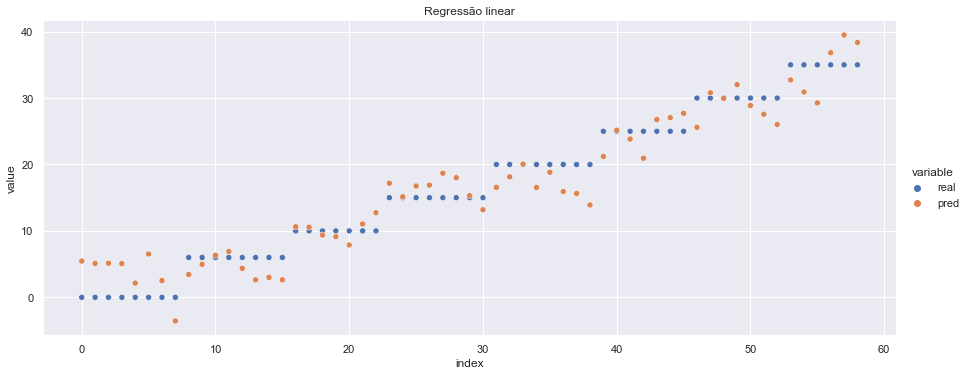

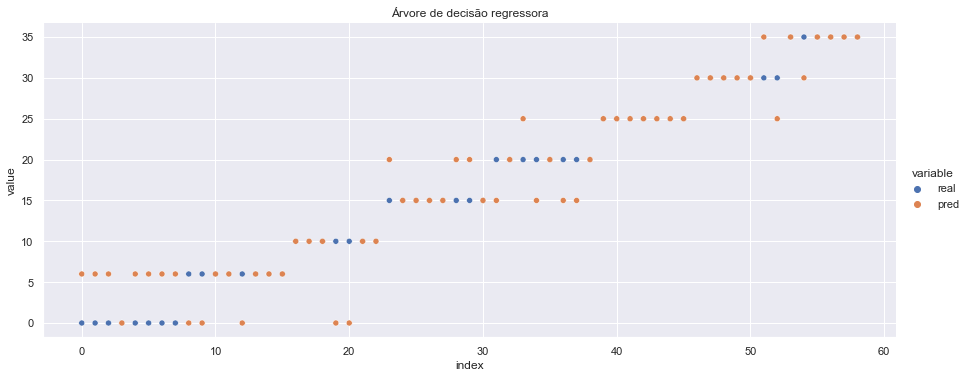

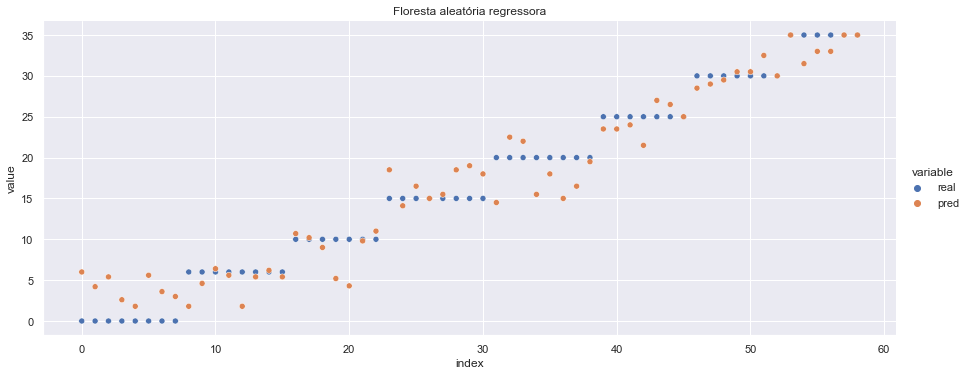

In [19]:
for i, modelo in enumerate(modelos):
    result = resultados[i].reset_index(drop=True).reset_index()
    result = result.melt(id_vars=['index', 'rotacao_discreta', 'erro'])
    sns.relplot(data=result, x='index', y='value', hue='variable', aspect=2.5)
    plt.title(modelo[0])

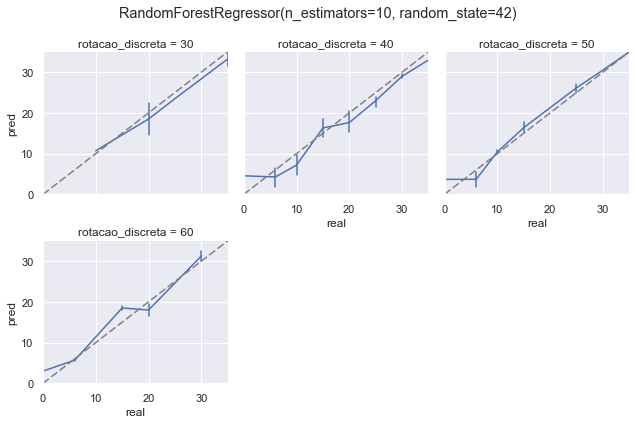

In [20]:
aux.plota_resultados_segregados(resultados[2], modelos[2][1], 'desbalanceamento')

### Conclusão
?

## Modelos baseados em árvore

In [21]:
regressores = df_norm

# salva a ordem das features
feature_list = list(regressores.columns)
# converte df para array
data = np.array(regressores)

modelos = [
    ('Árvore de decisão regressora',  DecisionTreeRegressor()  ),
    ('Floresta aleatória regressora', RandomForestRegressor(n_estimators= 10, random_state=42)  ),
]


# separa os conjuntos de treino e teste com amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size = 0.25, stratify=output, random_state=42) 

output_amostrado = pd.DataFrame( {'severidade': np.concatenate((y_test, y_train)),
                                  'fundamental': np.concatenate((X_test[:,0], X_train[:,0])),
                                  'conjunto': ['teste']*len(y_test) + ['treino']*len(y_train)} )


resultados = [None]*len(modelos)

for i, modelo in enumerate(modelos):
    # treina os modelos com dados de treino
    modelo[1].fit(X_train, y_train)

    # prevê com o modelo a partir do conjunto de teste
    y_predicted = modelo[1].predict(X_test)

    # salva DataFrame com resultados
    resultados[i] = aux.gera_df_resultados(X_test, feature_list, y_predicted, y_test)

    # salva métricas com o desempenho do modelo
    metricas = pd.concat([ metricas, aux.gera_df_metricas(y_predicted, y_test, modelo[0], 'normalizados') ], ignore_index=True)

metricas

,modelo,dados,R2,MSE,RMSE,MAE
0,Regressão linear,originais,0.924037,9.399241,3.065818,2.574334
1,Árvore de decisão regressora,originais,0.885621,14.152542,3.761986,2.288136
2,Floresta aleatória regressora,originais,0.938071,7.662712,2.768160,2.122034
3,Árvore de decisão regressora,normalizados,0.944523,6.864407,2.620001,1.271186
4,Floresta aleatória regressora,normalizados,0.964002,4.454237,2.110506,1.437288


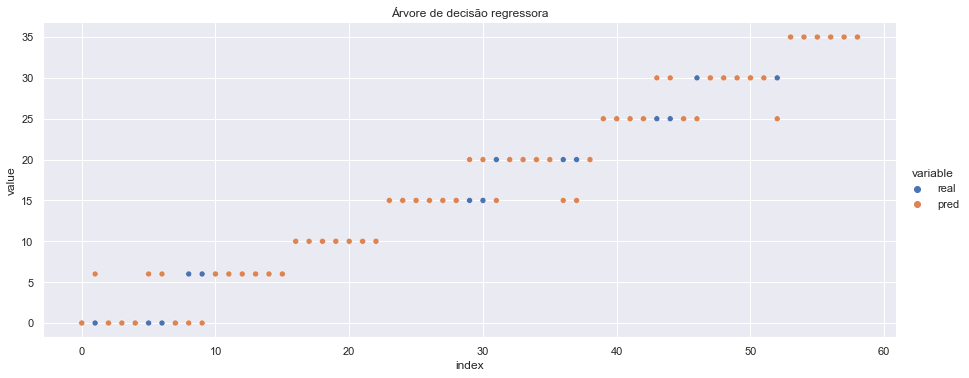

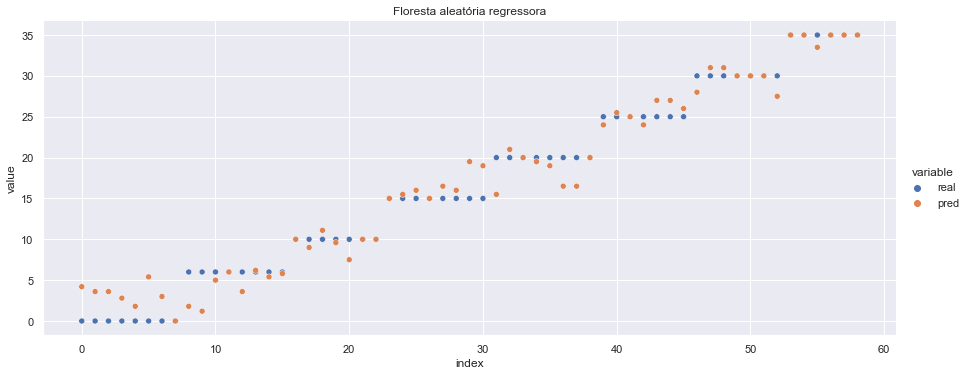

In [22]:
for i, modelo in enumerate(modelos):
    result = resultados[i].reset_index(drop=True).reset_index()
    result = result.melt(id_vars=['index', 'rotacao_discreta', 'erro'])
    sns.relplot(data=result, x='index', y='value', hue='variable', aspect=2.5)
    plt.title(modelo[0])

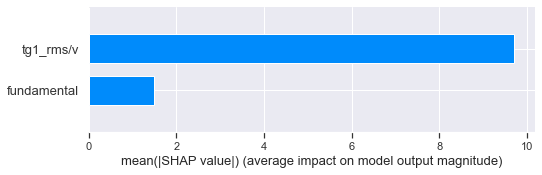

In [23]:
import shap

explainer = shap.TreeExplainer(modelos[1][1])
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, feature_list, plot_type="bar")

# TPOT <a class="anchor" id="TPOT"></a>
TPOT é um algoritmo Auto_ML, que gera o modelo otimizado após testes exaustivos.

In [24]:
#  a reexecução do TPOT pode levar horas, dias..

# from tpot import TPOTRegressor
# pipeline_optimizer_hor_mis = TPOTRegressor(verbosity=2)
# pipeline_optimizer_hor_mis.fit(X_train, y_train)

In [26]:
#  print(pipeline_optimizer_hor_mis.score(X_test, y_test))
#  pipeline_optimizer_hor_mis.export('tpot_pipeline_imbalance.py')

### Modelo gerado pelo TPOT (após 1 dia de busca)

In [27]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator

# Average CV score on the training set was: -0.009330433709391846
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=1.0, loss="exponential", n_estimators=100)),
    RandomForestRegressor(bootstrap=False, max_features=0.4, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
)


exported_pipeline.fit(X_train, y_train)
y_predicted = exported_pipeline.predict(X_test)


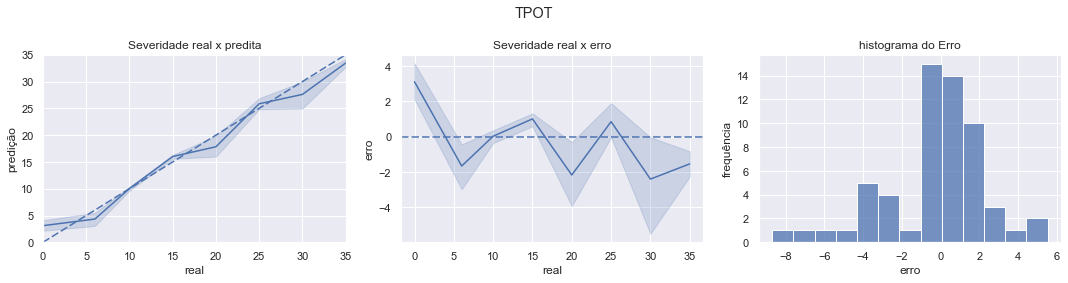

In [28]:
resultados_TPOT = aux.gera_df_resultados(X_test, feature_list, y_predicted, y_test)

aux.plota_resultados(resultados_TPOT, 'TPOT','desbalanceamento')

Text(0.5, 1.0, 'TPOT')

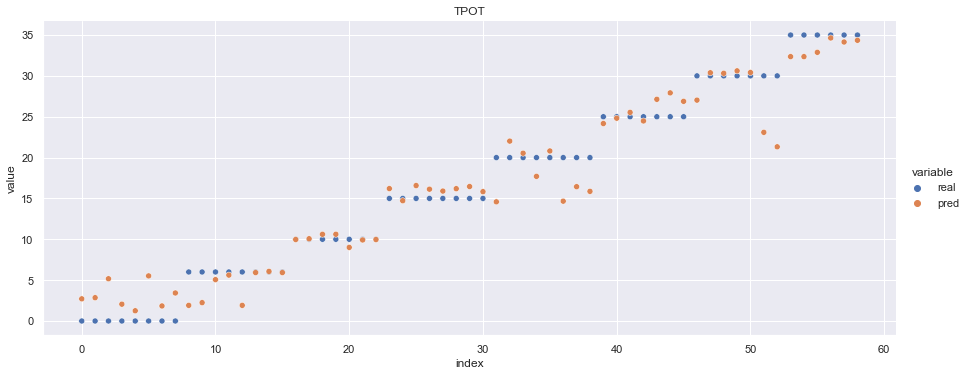

In [29]:
result = resultados_TPOT.reset_index(drop=True).reset_index()
result = result.melt(id_vars=['index', 'rotacao_discreta', 'erro'])
sns.relplot(data=result, x='index', y='value', hue='variable', aspect=2.5)
plt.title('TPOT')

In [30]:
metricas = pd.concat([ metricas, aux.gera_df_metricas(y_predicted, y_test, 'TPOT', 'normalizados') ], ignore_index=True)
metricas

,modelo,dados,R2,MSE,RMSE,MAE
0,Regressão linear,originais,0.924037,9.399241,3.065818,2.574334
1,Árvore de decisão regressora,originais,0.885621,14.152542,3.761986,2.288136
2,Floresta aleatória regressora,originais,0.938071,7.662712,2.768160,2.122034
3,Árvore de decisão regressora,normalizados,0.944523,6.864407,2.620001,1.271186
4,Floresta aleatória regressora,normalizados,0.964002,4.454237,2.110506,1.437288
5,TPOT,normalizados,0.942127,7.160900,2.675986,1.897518


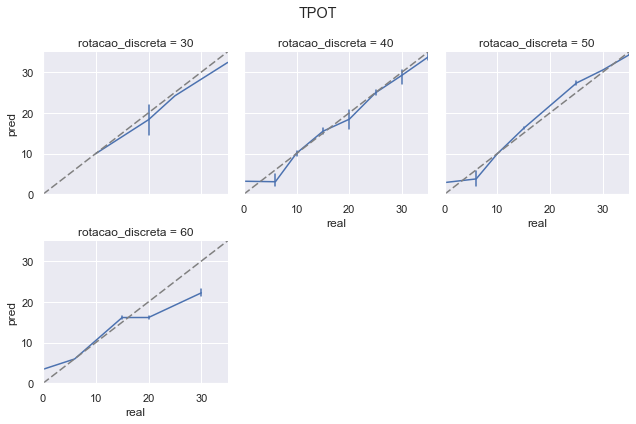

In [31]:
aux.plota_resultados_segregados(resultados_TPOT, 'TPOT', 'desbalanceamento')